## Synopsis
In this report, we attempt to predict the risk of the loan being default based on the past loan data. We obtained data from LendingClub’s website(https://www.lendingclub.com/info/download-data.action). We use loan data from year 2015 and perform data wrangling, explanatory data analysis and statistical hypotesting. We also split the data set into training and test data sets and apply tree based method to build predictive models for the loan status. We found that, among multiple machine learning algorithms that we tried, Gradient boosting method provided a reasonable trade-off performance, and a higher return than the naive loan picking strategy can be achieved.

In [1]:
import sys
from numpy import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import operator
%matplotlib inline

In [2]:
# read lending club stat file
df = pd.read_csv("LoanStats3d.csv",skiprows=1,low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421097 entries, 0 to 421096
Columns: 137 entries, id to hardship_last_payment_amount
dtypes: float64(104), object(33)
memory usage: 440.1+ MB


In [3]:
blank_columns = df.columns[df.isnull().all()].tolist()
blank_columns

['member_id',
 'url',
 'revol_bal_joint',
 'sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_open_acc',
 'sec_app_revol_util',
 'sec_app_open_il_6m',
 'sec_app_num_rev_accts',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_mths_since_last_major_derog']

In [4]:
# drop blank columns
df = df.drop(['id','member_id', 'url','revol_bal_joint','sec_app_earliest_cr_line','sec_app_inq_last_6mths','sec_app_mort_acc',
 'sec_app_open_acc','sec_app_revol_util','sec_app_open_il_6m','sec_app_num_rev_accts','sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med','sec_app_mths_since_last_major_derog'], axis = 1)

# drop post loan variables
df = df.drop(['out_prncp','out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
              'grade', 'sub_grade','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee',
              'collection_recovery_fee','last_pymnt_d','last_pymnt_amnt','next_pymnt_d','last_credit_pull_d',
              'payment_plan_start_date','issue_d',"funded_amnt_inv","loan_amnt",'num_tl_120dpd_2m','num_tl_30dpd'], axis = 1)
df = df.drop(['term','int_rate','installment'], axis = 1)

# drop hardship variables
df = df.drop(['hardship_flag','hardship_type','hardship_reason', 'hardship_status','hardship_start_date',
             'hardship_end_date','hardship_loan_status', 'hardship_amount','hardship_length','hardship_dpd',
              'hardship_payoff_balance_amount','hardship_last_payment_amount'], axis = 1)

## Object variable wrangling
### a. Target variable: How many class of loan status are there?

The target variable in the project is loan status. There are 7 types of loan status. Among them 'Current', 'Fully Paid' and 'In grace Peroid' mean that the lenders are paying the loan on time or have already paid the loan off. So these three status are called 'good loan'. And the rest four status mean the lenders have delayed the payment more than 15 days or even have no ability to make any payment at all. These four status are called 'bad loan'.

In [5]:
obj_df = df.select_dtypes(include=['object']).copy()
pd.unique(obj_df['loan_status'].values.ravel())

array(['Current', 'Fully Paid', 'Charged Off', 'Late (16-30 days)',
       'Late (31-120 days)', 'In Grace Period', 'Default', nan], dtype=object)

In [7]:
# classified loan_status to "good loan" and "bad loan"
status_dict = {'loan_status': {'Current':'good loan', 'Fully Paid':'good loan', 'In Grace Period':'good loan', 'Charged Off':'bad loan', 'Late (16-30 days)':'bad loan',
                'Late (31-120 days)':'bad loan', 'Default':'bad loan'}}
obj_df.replace(status_dict, inplace=True)
obj_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421097 entries, 0 to 421096
Data columns (total 16 columns):
emp_title                    397221 non-null object
emp_length                   421095 non-null object
home_ownership               421095 non-null object
verification_status          421095 non-null object
loan_status                  421095 non-null object
pymnt_plan                   421095 non-null object
desc                         45 non-null object
purpose                      421095 non-null object
title                        420963 non-null object
zip_code                     421095 non-null object
addr_state                   421095 non-null object
earliest_cr_line             421095 non-null object
revol_util                   420933 non-null object
initial_list_status          421095 non-null object
application_type             421095 non-null object
verification_status_joint    511 non-null object
dtypes: object(16)
memory usage: 51.4+ MB


In [8]:
# drop the variables which have more than 90% missing values
obj_df = obj_df.drop(['verification_status_joint', 'desc'], axis=1) 

### b. Data cleaning for other object variables

'title' is replicated in 'purpose' so we will drop them.

In [9]:
obj_df['purpose'].unique()

array(['debt_consolidation', 'credit_card', 'home_improvement',
       'major_purchase', 'house', 'medical', 'other', 'car',
       'small_business', 'vacation', 'moving', 'renewable_energy',
       'wedding', 'educational', nan], dtype=object)

In [10]:
obj_df['title'].unique()

array(['Debt consolidation', 'Credit card refinancing', 'Home improvement',
       nan, 'Major purchase', 'Home buying', 'Medical expenses', 'Other',
       'Car financing', 'Business', 'Vacation', 'Moving and relocation',
       'Green loan', 'odymeds', 'SAVE', 'Learning and training', 'new day',
       'Trying to come back to reality!', 'considerate',
       'Paying off higher interest cards & auto',
       'Simple Loan Until Contract Is Completed',
       'Prescription Drug and Medical Costs', 'Pay off Lowes Card',
       'new kitchen for momma!', 'DebtC',
       'New Baby and New House (CC Consolidate)',
       'Credit Card/Auto Repair', 'Student Loan'], dtype=object)

In [11]:
obj_df = obj_df.drop('title', axis=1)

In [12]:
#convert 'obj_df.revol_util' to numeric variable
obj_df.revol_util = pd.Series(obj_df.revol_util).str.replace('%', '').astype(float)

In [13]:
# convert emp_length to numeric variable
obj_df.emp_length.value_counts()

10+ years    141521
2 years       37497
< 1 year      34340
3 years       33430
1 year        27473
5 years       24930
4 years       24506
n/a           23817
8 years       21560
7 years       18414
6 years       16838
9 years       16769
Name: emp_length, dtype: int64

In [14]:
obj_df.replace('n/a', np.nan,inplace=True)
obj_df.emp_length.fillna(value=0,inplace=True)
obj_df['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
obj_df['emp_length'] = obj_df['emp_length'].astype(float)

### c. Feature  engineering

### emp_title
This variable has 120813 categories and we can choose the top ten employment tiltle and create 10 dummy variables so it can be used in model building.

In [15]:
obj_df.emp_title.unique().shape

(120813,)

In [16]:
obj_df['emp_title'].str.lower().value_counts().head(10)

teacher             9956
manager             8958
owner               6101
registered nurse    4443
supervisor          4080
driver              3863
sales               3759
rn                  3545
office manager      2826
project manager     2734
Name: emp_title, dtype: int64

In [17]:
# 'rn' should be the same as 'registered nurse'
obj_df['emp_title'] = obj_df['emp_title'].str.lower().replace('rn', 'registered nurse')

In [18]:
# select top ten employment title
cats = ['teacher','manager','registered nurse', 'owner','supervisor','driver','sales','office manager',
        'project manager','general manager']
obj_df.loc[~ (obj_df['emp_title'].isin(cats)), 'emp_title'] = 'other'
obj_df.emp_title.value_counts()

other               368270
teacher               9956
manager               8958
registered nurse      7988
owner                 6101
supervisor            4080
driver                3863
sales                 3759
office manager        2826
project manager       2734
general manager       2562
Name: emp_title, dtype: int64

### Zip code and state
These two variables can't be used directly for the analysis of loan status. But if they combined with the local unemployment rates in US they will be useful for the analysis.

In [19]:
obj_df['zip_code'] = obj_df['zip_code'].str.replace('xx', '00')
unemp_zip = pd.read_csv('unemploy_zip.csv')
unemp_zip.info()
unemp_zip.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855 entries, 0 to 854
Data columns (total 3 columns):
state       855 non-null object
zip_code    855 non-null int64
Rate        855 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 20.1+ KB


,state,zip_code,Rate
0,AK,99500,8.48
1,AK,99600,8.69
2,AK,99700,8.41


In [20]:
# concatenate the two files
obj_df['zip_code'] = obj_df['zip_code'].astype('float')
obj_df = obj_df.rename(columns={'addr_state':'state'})
unemp_zip['zip_code'] = unemp_zip['zip_code'].astype('float')
obj_df1 = pd.merge(obj_df, unemp_zip, on=['state','zip_code'], how='left')
obj_df1.Rate.count()

387468

The total observations for the data set are 421095. And there are 387468 observations for the 'Rate' variable. The reason is that there are 855 zip_unemployment rates in unemp_zip files while there are 915 zip codes in lending club dataset. So there would have missing values for the unemployment rate when these two files are merged together.

## Numerical variables wrangling

In [21]:
num_df = df.select_dtypes(include=['float']).copy()

In [24]:
# find the numerical variables which have more than 10% of outliers
for col in num_df.columns:
    Q1 = num_df[col].quantile(0.25)
    Q3 = num_df[col].quantile(0.75)
    IQR = Q3 - Q1
    out_liers_number = ((num_df[col] < (Q1 - 3 * IQR)) | (num_df[col] > (Q3 + 3 * IQR))).sum()
    count = df[col].count()
    if out_liers_number > (0.1 * count):
        print ("Column {} has {} outliers".format(col, out_liers_number)) 

#from scipy import stats
#df[(np.abs(stats.zscore(df)) > 3).all(axis=1)]

Column delinq_2yrs has 87087 outliers
Column pub_rec has 74415 outliers
Column tot_coll_amt has 66407 outliers
Column num_accts_ever_120_pd has 102993 outliers
Column pub_rec_bankruptcies has 50916 outliers


In [25]:
# concat object variable files and numeric variable file
obj_df1['zip_code'] = obj_df1['zip_code'].astype('object')
df1 = pd.concat([obj_df1, num_df], axis=1 )

## Explanatory Data Analysis

#### How many good loans and bad loans are there?

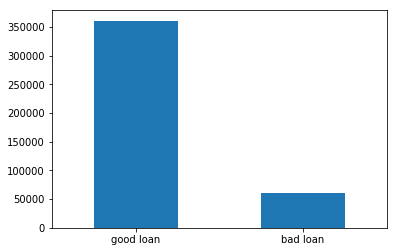

In [26]:
_ = df1['loan_status'].value_counts().plot(kind='bar')
_.set_xticklabels(['good loan', 'bad loan'], rotation=0)

Among all the loans about 20% is bad loans and 80% is good loans.

#### The relationship between loan status and employment title

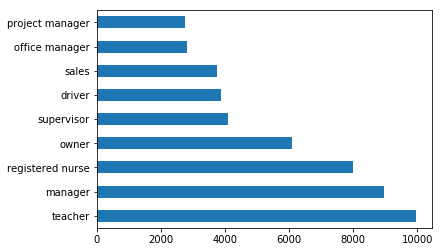

In [27]:
df1['emp_title'].value_counts()[1:10].plot(kind='barh')

Teacher is the occupation which has the largest number of loans. And project manager has lowest number of loans.

In [28]:
# create a function to caculate good loan/bad loan for different variables and their percentages
def calculation(col, col_cats):
    df2=df1[df1[col].isin(col_cats)][['loan_status', col]]
    good_loan_data = df2[df2.loan_status == 'good loan']
    bad_loan_data = df2[df2.loan_status == 'bad loan']

    good_loan = good_loan_data.groupby(col).size().sort_values(ascending=False).values
    bad_loan = bad_loan_data.groupby(col).size().sort_values(ascending=False).values

    totals = good_loan + bad_loan
    data1_percentages = (good_loan/totals)*100 
    data2_percentages = (bad_loan/totals)*100
    return good_loan,bad_loan,data1_percentages,data2_percentages

In [29]:
# create plot function
def plot(xticks, col, col_cats):
    
    good_loan,bad_loan,data1_percentages,data2_percentages = calculation(col, col_cats)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    # plot chart for count of loan status by col
    ax1.bar(range(len(good_loan)), good_loan, label='Good_loan', alpha=0.7, color='b')
    ax1.bar(range(len(bad_loan)), bad_loan, bottom=good_loan, label='Bad_loan', alpha=0.7, color='r')
    plt.sca(ax1)
    plt.xticks(xticks, col_cats, rotation=45, ha='right')
    ax1.set_ylabel("Count")
    ax1.set_xlabel("")
    ax1.set_title("Count of loan status by {}".format(col),fontsize=14)
    plt.legend(loc='upper right')

    # plot chart for percentage of loan status by col
    ax2.bar(range(len(data1_percentages)), data1_percentages, alpha=0.7, color='b')
    ax2.bar(range(len(data2_percentages)), data2_percentages, bottom=data1_percentages, alpha=0.7, color='r')
    plt.sca(ax2)
    plt.xticks(xticks, col_cats, rotation=45, ha='right')
    ax2.set_ylabel("Percentage")
    ax2.set_xlabel("")
    ax2.set_title("% of loan status by {}".format(col),fontsize=14)

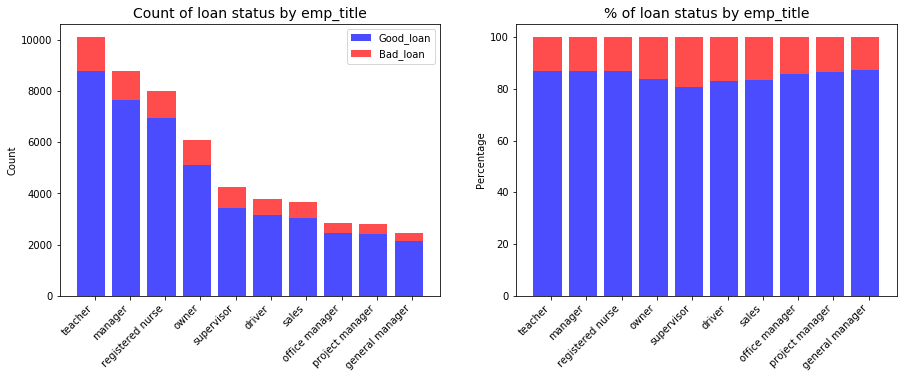

In [30]:
xticks = [0.1, 1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1, 9.1]
emp_title_categories = ['teacher','manager','registered nurse', 'owner','supervisor','driver','sales','office manager',
        'project manager','general manager']
plot(xticks,'emp_title', emp_title_categories)

Although teachers have largest number of loans they have relatively low bad loan percentage as project managers.

#### The relationship between loan status and home ownership

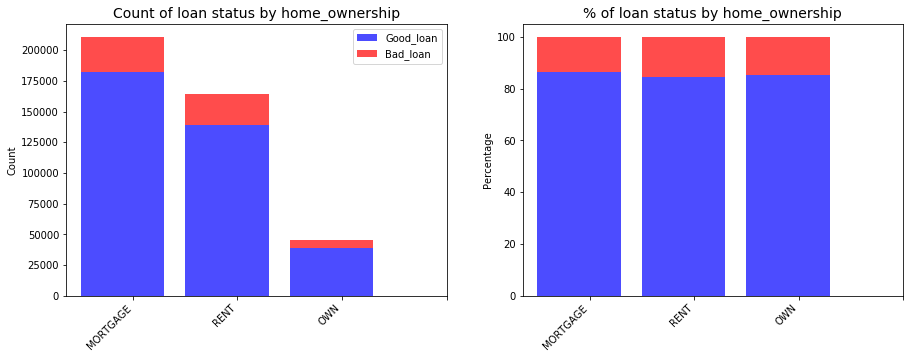

In [31]:
xticks = [0.1, 1.1, 2.1, 3.1]
home_ownership_categories = ['MORTGAGE','RENT','OWN']
plot(xticks,'home_ownership', home_ownership_categories)

The people who have mortgage have largest number of loans while their bad loan percentage is relatively low compare to the renters/home owners.

#### The relationship of zip code, unemployment rate and bad loan percentage

What is the mean unemployment rate in zip codes for bad/good loans?

In [32]:
data = df1.loc[df1.loan_status == 'bad loan', ['state', 'zip_code', 'Rate', 'loan_status']].groupby(['state', 'zip_code']).mean()
data = data.reset_index()
data.sort_values('Rate', ascending=False, inplace=True)
data.head()

,state,zip_code,Rate
84,CA,92200.0,15.37
302,KY,41600.0,12.05
904,WV,24800.0,11.92
57,AZ,86500.0,11.55
438,MS,38700.0,11.31


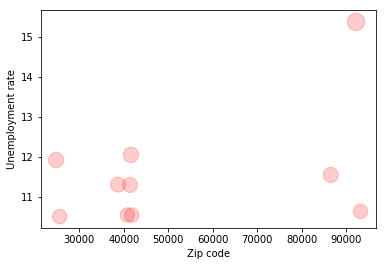

In [33]:
# top ten mean unemployment rate in zip codes for bad/good loans
plt.scatter(data['zip_code'].values[:10], data['Rate'].values[:10], 
            alpha=0.2, s=20*data['Rate'].values[:10],c='red')
plt.xlabel('Zip code')
plt.ylabel('Unemployment rate')

The top ten unemployment rates locate in three zip codes area(20000, 40000, 90000).States CA and AZ's zip codes are around 90000, KY is around 40000, WV and MS are around 20000.

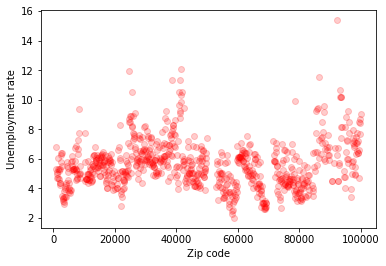

In [36]:
# mean unemployment rate in zip codes for bad/good loans
plt.scatter(data['zip_code'], data['Rate'], alpha=0.2, c='red')
plt.xlabel('Zip code')
plt.ylabel('Unemployment rate')

Will the loan lenders in the five states(CA, AZ, KY, WV and MS) which have high unemployment rates also have high bad loan percentage?

In [37]:
# caculation of bad loan percentage in zip code
def bad_loan_perc_zip(DF):
    new1 = DF.loc[DF.loan_status == 'good loan', ['state', 'zip_code', 'Rate', 'loan_status']]
    new2 = DF.loc[DF.loan_status == 'bad loan', ['state', 'zip_code', 'Rate', 'loan_status']]

    a = pd.DataFrame(new1.groupby(['state', 'zip_code', 'Rate'])['loan_status'].size())
    a = a.reset_index()

    b = pd.DataFrame(new2.groupby(['state', 'zip_code', 'Rate'])['loan_status'].size())
    b = b.reset_index()

    total = pd.merge(a, b, on=['state','zip_code'], how='left').drop('Rate_y', axis=1)
    total.fillna(0, inplace=True)
    total['bad_loan_perc'] = (total['loan_status_y']/(total['loan_status_x'] + total['loan_status_y'])) * 100
    return total

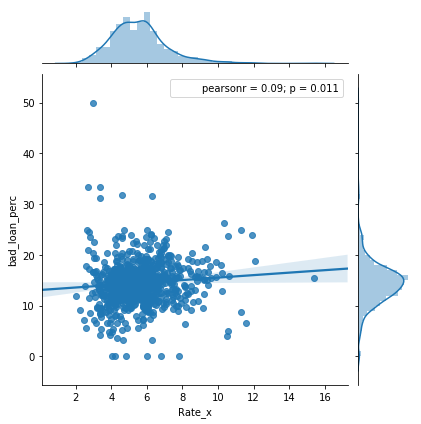

In [39]:
# plot the bad loan percentage with unemployment rate in the same zip code area
import seaborn as sns
total = bad_loan_perc_zip(df1)
sns.jointplot('Rate_x', 'bad_loan_perc', data=total, kind='reg')

From the above plot we can see that the higher the unemployment rate is the higher the bad loan percentage. So we should pay attention to the loan applicants from the five states(CA, AZ, KY, WV and MS) which have high unemployment rates.

* What is the relationship between reported unemployment rate (by
applicants in employment status) and average unemployment rate? What
about with respect to bad/good loans? In other words, are people that
are accepted for a loan (or pay back a loan or don't pay back a loan)
typically more unemployed than the rest of the population?

In [40]:
# get unemployment rate of unloanded population
new = unemp_zip[['Rate']]  
new['loan_status'] = ['unloaned'] * 855

# get enemployment rate of good loan lenders and bad loan lenders
new1 = df1.loc[df1.loan_status == 'good loan', ['Rate', 'loan_status']]
new2 = df1.loc[df1.loan_status == 'bad loan', ['Rate', 'loan_status']]

# concatenate the three files 
frames = [new, new1, new2]
new_total = pd.concat(frames)
new_total.info()

C:\Users\yepeng\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<class 'pandas.core.frame.DataFrame'>
Int64Index: 421950 entries, 0 to 421093
Data columns (total 2 columns):
Rate           388323 non-null float64
loan_status    421950 non-null object
dtypes: float64(1), object(1)
memory usage: 9.7+ MB


In [41]:
print("Unloaded population' mean unemployment rate: " + str(new.Rate.mean()))
print("Good loan lenders' mean unemployment rate: " + str(new1.Rate.mean()))
print("Bad loan lenders' mean unemployment rate: " + str(new2.Rate.mean()))

Unloaded population' mean unemployment rate: 5.523099415204683
Good loan lenders' mean unemployment rate: 5.4941326246224715
Bad loan lenders' mean unemployment rate: 5.554777603913014


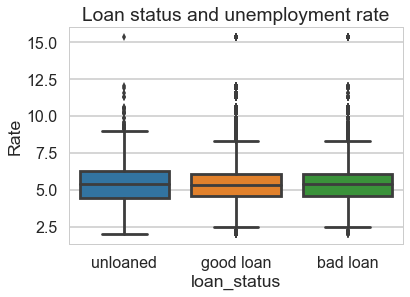

In [42]:
sns.set_style("whitegrid")
sns.set_context("poster")
_ = sns.boxplot(x='loan_status', y='Rate', data=new_total)
plt.title('Loan status and unemployment rate')

From the above figure we can see the mean unemployment rate for good loan lenders is lower than that of unloaded population and bad loan lenders. The mean calculation shows the mean unemployment rate for unloaded population is lower than that of bad loan lenders.

In other words, people that are accepted for a loan and pay back a loan on time typically more employed than the rest of the population. While people that are accepted for a loan and don't pay back a loan typically more unemployed than the rest of the population.

#### The relationship of employment length and bad loan percentage

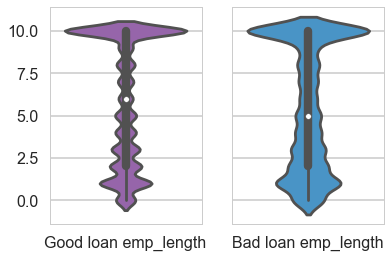

In [43]:
g_loan = df1[df1.loan_status == 'good loan'][['emp_length']]
g_loan.columns = ["Good loan emp_length"]

b_loan = df1[df1.loan_status == 'bad loan'][['emp_length']]
b_loan.columns = ["Bad loan emp_length"]

fig, axs = plt.subplots(ncols=2, sharey=True)
sns.violinplot(data=g_loan, ax=axs[0], color='#9b59b6')
sns.violinplot(data=b_loan, ax=axs[1], color='#3498db')

#### Can you count something interesting?
Teacher is the occupation which has the largest number of loans. And project manager has lowest number of loans. Although teachers have largest number of loans they have relatively low bad loan percentage as project managers. See the plot "The relationship between loan status and employment title"

The top ten unemployment rates locate round three zip codes area(20000, 40000, 90000).States CA and AZ's zip codes are around 90000, KY is around 40000, WV and MS are around 20000. If unemployment rate is correlated with bad loan percentage we should pay attention to the loan applicants from these five states.

#### Can you find some trends (high, low, increase, decrease, anomalies)?
I found that the higher the unemployment rate is the higher the bad loan percentage. So we should pay attention to the loan applicants from the five states(CA, AZ, KY, WV and MS) which have high unemployment rates.


I made bar plot, histogram, box plot to compare two related quantities and scatterplot. And this data set I didn't made a time-series plot for the time variables are all post loan variables and they have been deleted in the data wrangling.

#### Having made these plots, what are some insights you get from them? Do you see any correlations? Is there a hypothesis you would like to investigate further? What other questions do they lead you to ask?
Insights: 
1. Bad loan's percentage is about 20% in 2015.
2. Teacher rank first in the top ten occupation of borrows while they seem to have relative loan bad loan percentage. Teacher’s salary is low and they have great demand of loan. But they also have better credit to pay off the debt on time than other occupations. Supervisor seems to have the highest bad loan percentage and the reason is unknown. 
3. The top ten unemployment rates locate round three zip codes area(20000, 40000, 90000).States CA and AZ's zip codes are around 90000, KY is around 40000, WV and MS are around 20000.I found that the higher the unemployment rate is the higher the bad loan percentage. So we should pay attention to the loan applicants from the five states(CA, AZ, KY, WV and MS) which have high unemployment rates.
4. The mean unemployment rate for good loan lenders is lower than that of unloaded population and bad loan lenders. The mean calculation shows the mean unemployment rate for unloaded population is lower than that of bad loan lenders.
In other words, people that are accepted for a loan and pay back a loan on time typically more employed than the rest of the population. While people that are accepted for a loan and don't pay back a loan typically more unemployed than the rest of the population.
5. Average employment length of good loan lenders is higher than bad loan lenders.

Hypothesis to investigate further:
1. if the top ten employment title holders have different bad loan percentage.
2. if home ownership has effect on bad loan percentage.
3. if unemployment rate correlates with bad loan percentage in the same zip code area.
4. if the mean employment time for good loan lenders differs from bad loan lenders.

#### By now you’ve asked a bunch of questions, and found some neat insights. Is there an interesting narrative, a way of presenting the insights using text and plots from the above, that tells a compelling story? As you work out this story, what are some other trends/relationships you think will make it more complete?

Story: Bad loan percentage is still high in 2015(20%). Bad loan lenders seem to have shorter employment length, to be a home owner or to work as a superviser. Bad loan percentage seems to increase with the unemployment rate in the same zip code area.

To work out the story I need to do statistical testing to test the trends. And I also need to investigate the relationsip between the numerical variables to see if they are correlated. Finally I will build a model to predict loan status.

## Statistical Analysis

### Numeric variables correlation analysis

In [44]:
# calculate correlation coefficient of the numeric variables
num_df = df.select_dtypes(include=['float']).copy()
cor = num_df.corr()

# find the highly correlated variables
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = pd.DataFrame(cor.stack())
cor.rename(columns = {0 :'correlation'}, inplace = True)
cor_75 = cor[(cor.correlation > 0.75) | (cor.correlation < -0.75)]
cor_75 = cor_75.reset_index()
cor_75.rename(columns={'level_0':'variable_0', 'level_1':'variable_1'}, inplace=True)
cor_75.head()

,variable_0,variable_1,correlation
0,open_il_24m,open_il_12m,0.760552
1,open_rv_24m,open_rv_12m,0.767262
2,total_rev_hi_lim,revol_bal,0.833423
3,acc_open_past_24mths,open_rv_24m,0.842395
4,avg_cur_bal,tot_cur_bal,0.834840


In [45]:
#slice the first ten correlated pair of variables
a = cor_75.variable_0.values[:10]
b = cor_75.variable_1.values[:10]
c = list(a) + list(b)
c = set(c)
print(c)

{'mths_since_last_delinq', 'acc_open_past_24mths', 'open_rv_12m', 'total_rev_hi_lim', 'avg_cur_bal', 'num_bc_sats', 'open_il_12m', 'mths_since_recent_revol_delinq', 'num_actv_rev_tl', 'tot_cur_bal', 'num_actv_bc_tl', 'open_rv_24m', 'mths_since_recent_bc_dlq', 'open_il_24m', 'revol_bal'}


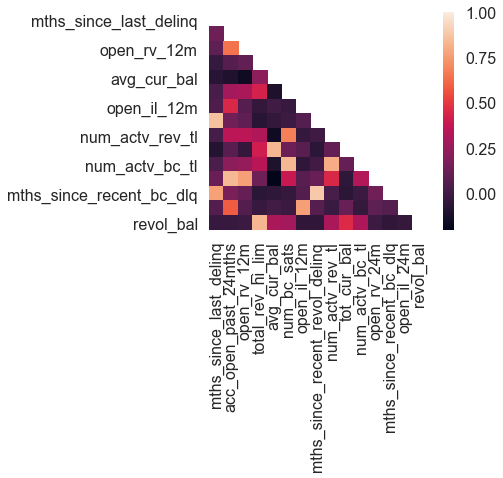

In [59]:
# correlation hotmap for the selected variables
high_cor = num_df[['mths_since_last_delinq', 'acc_open_past_24mths', 'open_rv_12m', 'total_rev_hi_lim',
                   'avg_cur_bal', 'num_bc_sats', 'open_il_12m', 'mths_since_recent_revol_delinq', 
                   'num_actv_rev_tl', 'tot_cur_bal', 'num_actv_bc_tl', 'open_rv_24m', 
                   'mths_since_recent_bc_dlq', 'open_il_24m', 'revol_bal']]
high_corr = high_cor.corr()
mask = np.zeros_like(high_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(high_corr, mask=mask, vmax=1, square=True)

In [ ]:
'acc_open_past_24mths','avg_cur_bal','funded_amnt','mths_since_last_delinq',
 'mths_since_recent_bc_dlq','mths_since_recent_revol_delinq','open_il_12m','open_il_24m','open_rv_12m','open_rv_24m','revol_bal',
 'tot_cur_bal','total_rev_hi_lim'

### Chi squrare test for the loan status and employment title

 it tests whether the distribution of sample categorical data matches an expected distribution.

In [48]:
def create_table(DF, col, colcats): 
    df = DF[DF[col].isin(colcats)][[ 'loan_status', col]]
    Con_Table = pd.crosstab(df.loan_status, df[col], margins=True) 
    Con_Table.columns =  colcats +['row_totals']
    Con_Table.index = ['good','bad', 'col_totals']
    return Con_Table, df 

In [49]:
Con_Table, df = create_table(df1, 'emp_title', emp_title_categories)
Con_Table

,teacher,manager,registered nurse,owner,supervisor,driver,sales,office manager,project manager,general manager,row_totals
good,817,403,1319,379,987,313,1044,610,642,1162,7676
bad,3046,2159,7639,2447,5114,2421,6944,3149,3438,8794,45151
col_totals,3863,2562,8958,2826,6101,2734,7988,3759,4080,9956,52827


In [50]:
# get observed value and expected value
observed = Con_Table.iloc[0:2, 0:10]

expected =  np.outer(Con_Table["row_totals"][0:2],
                     Con_Table.iloc[2, 0:10]) / 52827

expected = pd.DataFrame(expected)

expected.columns = emp_title_categories
expected.index = ['good','bad']

expected

,teacher,manager,registered nurse,owner,supervisor,driver,sales,office manager,project manager,general manager
good,561.311223,372.270089,1301.637572,410.630473,886.50266,397.26246,1160.692222,546.199557,592.842297,1446.651447
bad,3301.688777,2189.729911,7656.362428,2415.369527,5214.49734,2336.73754,6827.307778,3212.800443,3487.157703,8509.348553


In [51]:
import scipy.stats as stats
def chi_square_test(freedom):
    # chi square statistics
    chi_squared_stat = (((observed-expected)**2)/expected).sum().sum()

    print('chi_squared_stat: ' + str(chi_squared_stat))

    crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                          df = freedom)  

    print("Critical value: " + str(crit))

    p_value = 1 - stats.chi2.cdf(x=chi_squared_stat,  # Find the p-value
                                df=freedom)
    print("P value: " + str(p_value))

chi_square_test(12)

chi_squared_stat: 269.3493768308436
Critical value: 21.0260698175
P value: 0.0


### Chi square test for loan status and home ownership

In [52]:
Con_Table, df = create_table(df1, 'home_ownership', home_ownership_categories)
Con_Table

,MORTGAGE,RENT,OWN,row_totals
good,25314,6778,28354,60446
bad,182369,38988,139290,360647
col_totals,207683,45766,167644,421093


In [53]:
# get observed value and expected value
observed = Con_Table.iloc[0:2, 0:3]

expected =  np.outer(Con_Table["row_totals"][0:2],
                     Con_Table.iloc[2, 0:3]) / 421093

expected = pd.DataFrame(expected)

expected.columns = home_ownership_categories
expected.index = ['good','bad']

In [54]:
chi_square_test(5)

chi_squared_stat: 1692.8473338733406
Critical value: 11.0704976935
P value: 0.0


### Kruskal-Wallis H-test for the median of employment length of different loan status

In [55]:
median_emp_length = df1.groupby('loan_status')['emp_length'].median()
median_emp_length

loan_status
bad loan     5.0
good loan    6.0
Name: emp_length, dtype: float64

The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal. It is a non-parametric version of ANOVA. The test works on 2 or more independent samples, which may have different sizes. Note that rejecting the null hypothesis does not indicate which of the groups differs. Post-hoc comparisons between groups are required to determine which groups are different.

In [56]:
g_loan = df1[df1.loan_status == 'good loan'][['emp_length']]
a = g_loan['emp_length']

b_loan = df1[df1.loan_status == 'bad loan'][['emp_length']]
b = b_loan['emp_length']

print("Kruskal Wallis H-test test:")

H, pval = stats.kruskal(a, b)

print("H-statistic:", H)
print("P-Value:", pval)

if pval < 0.05:
    print("Reject NULL hypothesis - Significant differences exist between groups.")
if pval > 0.05:
    print("Accept NULL hypothesis - No significant difference between groups.")

Kruskal Wallis H-test test:
H-statistic: 189435635.441
P-Value: 0.0
Reject NULL hypothesis - Significant differences exist between groups.


C:\Users\yepeng\Anaconda3\lib\site-packages\scipy\stats\stats.py:5056: RuntimeWarning: overflow encountered in long_scalars
  h = 12.0 / (totaln * (totaln + 1)) * ssbn - 3 * (totaln + 1)


### Two sample t-test for the mean of unemployment rate in good loan borrowers and bad loan lenders

In [57]:
mean_unemp_rate = df1.groupby('loan_status')['Rate'].mean()
mean_unemp_rate 

loan_status
bad loan     5.554778
good loan    5.494133
Name: Rate, dtype: float64

In [58]:
good_loan = df1[df1.loan_status == 'good loan'][['Rate']].dropna()
x = good_loan['Rate']

bad_loan = df1[df1.loan_status == 'bad loan'][['Rate']].dropna()
y = bad_loan['Rate']

t, p = stats.ttest_ind(x, y, equal_var=False)
print("ttest_ind:            t = %g  p = %g" % (t, p))

ttest_ind:            t = -9.58285  p = 9.71499e-22


### Statistical Analysis report


1.correlation analysis

There are more than 30 pairs of numeric variables highly correlate and the correlation coefficient are over 0.75.


2.Chi squrare test for the loan status and employment title

Hypothesis

H 0  : In the population, variable'loan_status' and variable 'emp_title' are independent.
H 1  : In the population, variable'loan_status' and variable 'emp_title' are dependent. 

Test statistics

chi_squared_stat: 269.3493768308436
Critical value: 21.0260698175
P value: 0.0

Conclusion:

We reject H 0 and consider variable'loan_status' and variable 'emp_title are dependent. In other words loan status dependend on what kind of employment title of the borrowers.

3.Chi square test for loan status and home ownership

Hypothesis

H 0  : In the population, variable'loan_status' and variable 'home_ownership' are independent.
H 1  : In the population, variable'loan_status' and variable 'home_ownership' are dependent.

Test Statistics

chi_squared_stat: 1692.8473338733406
Critical value: 11.0704976935
P value: 0.0

Conclusion:

We reject H 0 and consider variable'loan_status' and variable 'home_ownership' are dependent. It means loan status dependend on whether borrowers are renting a home or have purchased house.

4.Kruskal-Wallis H-test for the median of employment length of different loan status

The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal. It is a non-parametric version of ANOVA. The test works on 2 or more independent samples, which may have different sizes. Note that rejecting the null hypothesis does not indicate which of the groups differs. Post-hoc comparisons between groups are required to determine which groups are different.

Hypothersis:

H 0: The population median of employment length in good loan borrowers and bad loan borrowers are equal.
H 1: The population median of employment length in good loan borrowers and bad loan borrowers are not equal.

Test statistics:

Kruskal Wallis H-test test:
H-statistic: 189435635.441
P-Value: 0.0

Conclusion:We reject H 0 and consider the population median of employment length in good loan borrowers and bad loan borrowers are equal. The median of good loan borrowers' employment length is higher than that of bad loan borrowers.

5. Two sample t-test for the mean of unemployment rate in good loan borrowers and bad loan borrowers

Hypothesis:

H 0: The population mean of unemployment rate of good loan borrowers and bad loan borrowers are equal.
H 1: The population mean of unemployment rate of good loan borrowers and bad loan borrowers are not equal.

Test statistics:

ttest_ind:            t = -9.58285  p = 9.71499e-22

Conclusions:

We reject H0 and consider the mean of unemployment rate of good loan borrowers is lower than that of the bad loan borrowers.

# Model building

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

### Data preprocessing

In [61]:
df2 = df1.dropna(subset=['loan_status'])
df2['loan_status'].value_counts(dropna=False)

good loan    360649
bad loan      60446
Name: loan_status, dtype: int64

#### Extract 'year' from variable 'earliest_cr_line'

In [62]:
import datetime as dt
year_list = []
for time in df2['earliest_cr_line']:
    year = dt.datetime.strptime(time, '%b-%Y').year              
    year_list.append(year)

df2.loc[0:421095, 'earliest_cr_line'] = year_list

C:\Users\yepeng\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [63]:
# convert all the object variables to dummy variabls
df3 = pd.get_dummies(df2, columns=['home_ownership', 'verification_status', 'pymnt_plan',
                                   'purpose', 'initial_list_status', 'application_type', 'emp_title'])

df3['loan_status'] = df3['loan_status'].map({'good loan':0,'bad loan':1})

#'policy_code' only have '1' and 'NaN' values 
df3 = df3.drop(['zip_code', 'state','policy_code'], axis=1) 

#### Imputing missing values of predictors with mean

In [64]:
df4 = df3.drop('loan_status', axis = 1)
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
imputer = imputer.fit(df4)
imputed_data = imputer.transform(df4.values)

In [65]:
X = imputed_data
y = df3['loan_status'].values

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state = 0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(252657, 112)
(168438, 112)
(252657,)
(168438,)


### Decision Tree 

In [33]:
# use cross validation to tune hyperparameter of decision tree algorithm
from sklearn.model_selection import cross_val_score
depth = []
for i in range(3,10):
    clf = tree.DecisionTreeClassifier(max_depth=i,min_samples_leaf=50)
    # Perform 7-fold cross validation 
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=7, n_jobs=4)
    depth.append((i,scores.mean()))
print(depth)

[(3, 0.85669108733167099), (4, 0.85671483517706548), (5, 0.85673066729330494), (6, 0.85673066729330494), (7, 0.85663567777590433), (8, 0.85623987914651389), (9, 0.85584804742844656)]


From the scores we obtained from the tuning process max_depth equaling 5 or 6 is the best choice.

In [34]:
# training decision tree model with 'gini index' criterion
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 0,
                               max_depth=6, min_samples_leaf=50)
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [35]:
# training decision tree model with 'entropy' criterion
clf_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 0,
                                     max_depth=6, min_samples_leaf=50)
clf_entropy.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [36]:
# testing the decision tree models
y_pred_gi = pd.DataFrame(clf_gini.predict_proba(X_test)).iloc[:,1]
y_pred_en = pd.DataFrame(clf_entropy.predict_proba(X_test)).iloc[:,1]

In [37]:
# use roc_aus matrix to score the decision tree models
from sklearn.metrics import roc_auc_score
print("AUC - ROC gini : ", roc_auc_score(y_test, y_pred_gi))
print("AUC - ROC entropy : ", roc_auc_score(y_test, y_pred_en))

AUC - ROC gini :  0.636293062904
AUC - ROC entropy :  0.637417236881


The score of the model using 'entropy' is a little bit higher than that using 'gini index'.

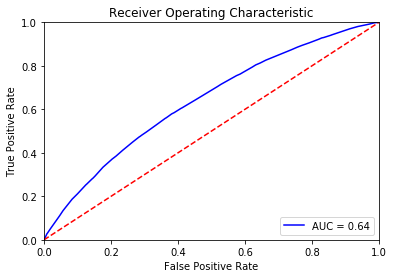

In [38]:
# plot roc_auc cure of decision tree model
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def roc_auc_curve(y, preds):
    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

roc_auc_curve(y_test, y_pred_en)

### Random Forest

#### compare the feature importance

In [39]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df4.columns
forest = RandomForestClassifier(n_estimators=1000, oob_score = True, random_state=0, n_jobs=-1,
                                max_features = "auto", min_samples_leaf = 50)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[f],importances[indices[f]]))

 1) emp_length                     0.061432
 2) earliest_cr_line               0.058367
 3) revol_util                     0.044979
 4) Rate                           0.040004
 5) funded_amnt                    0.037900
 6) annual_inc                     0.035266
 7) dti                            0.034621
 8) delinq_2yrs                    0.030147
 9) inq_last_6mths                 0.030045
10) mths_since_last_delinq         0.029514
11) mths_since_last_record         0.028132
12) open_acc                       0.027119
13) pub_rec                        0.025924
14) revol_bal                      0.025657
15) total_acc                      0.024297
16) collections_12_mths_ex_med     0.023379
17) mths_since_last_major_derog    0.022589
18) annual_inc_joint               0.021541
19) dti_joint                      0.020744
20) acc_now_delinq                 0.019778
21) tot_coll_amt                   0.019758
22) tot_cur_bal                    0.019104
23) open_acc_6m                 

Emp_length and rate variables are among the top five important features. We discussed these two features in EDA part and found them be important to the loan status. So the modeling building part agrees with the EDA part on these two variables.

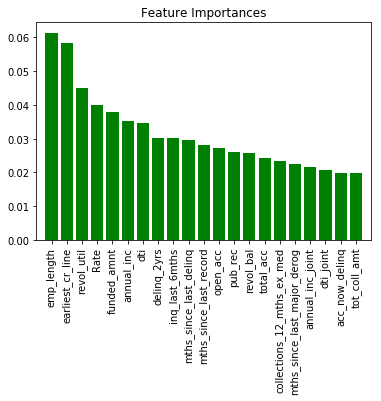

In [40]:
#create importance plot using top 20 important features
plt.title('Feature Importances')
plt.bar(range(21), importances[indices][0:21], 
                     color='green', align='center')
plt.xticks(range(21),
          feat_labels[0:21], rotation=90)
plt.xlim([-1, 21])
plt.show()

#### score the random forest model and plot roc curve

AUC - ROC :  0.685429548391


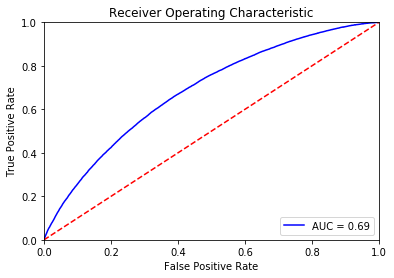

In [41]:
y_pred_rf = pd.DataFrame(forest.predict_proba(X_test)).iloc[:,1]
print("AUC - ROC : ", roc_auc_score(y_test, y_pred_rf))
roc_auc_curve(y_test, y_pred_rf)

Decision tree model's auc_roc score is 0.64 and random forest model get the score 0.69.

### Gradient Boosting Method

In [42]:
from sklearn.ensemble import GradientBoostingClassifier #For Classification

#### tuning the learning rate 

In [43]:
from sklearn.model_selection import cross_val_score
learning_rate = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]
append = []
for i in learning_rate:
    clf = GradientBoostingClassifier(learning_rate=i)
    # Perform 5-fold cross validation 
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5, n_jobs=4)
    estimator = append.append(scores)
    print('learning rate ' + str(i) + ' mean scores: ' + str(scores.mean()))

learning rate 0.0001 mean scores: 0.856691087231
learning rate 0.001 mean scores: 0.856691087231
learning rate 0.005 mean scores: 0.856691087231
learning rate 0.01 mean scores: 0.856691087231
learning rate 0.05 mean scores: 0.856885026801
learning rate 0.1 mean scores: 0.85705917701


Learning rate decides the number of trees. The lower the learning rate the more of trees needed. Learning rate 0.1 performs better than other smaller rates.

#### training and scoring the model

In [52]:
#try learning rate 0.1, 0.2, 0.3 and 0.5 and 0.2 is the best one
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.2, max_depth=2)
clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

AUC - ROC :  0.695163470515


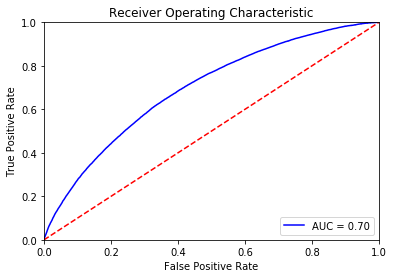

In [53]:
y_pred_gb = pd.DataFrame(clf.predict_proba(X_test)).iloc[:,1]
print("AUC - ROC : ", roc_auc_score(y_test, y_pred_gb))
roc_auc_curve(y_test, y_pred_gb)

GBM model gets a score of 0.70 and a little bit improvment than the random Forest.